# Choppy Market - Strategy by ChatGPT - Backtesting 

### Import Library

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy
from backtesting._plotting import set_bokeh_output
set_bokeh_output(notebook=False)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

/home/zuongthao/PycharmProjects/algo-stock/venv/lib/python3.11/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

### Load Price Data

In [2]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [3]:
data = dataset.copy()

In [4]:
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
data = data[data.index > '2020-11-01 00:00:00']

In [5]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2025-02-07 14:15:00,1343.3,1344.4,1342.4,1344.2,5075
2025-02-07 14:20:00,1344.2,1344.7,1343.6,1344.0,4865
2025-02-07 14:25:00,1344.1,1344.2,1342.8,1343.3,5013


In [13]:
df = data.copy()
# Calculate ATR (Average True Range) to measure volatility
df["ATR"] = ta.atr(df["High"], df["Low"], df["Close"], length=14)

# Calculate 50 EMA to check for trend
df["EMA_50"] = ta.ema(df["Close"], length=50)

# Measure EMA slope to detect choppiness
df["EMA_Slope"] = df["EMA_50"].diff()

# Define choppy market condition
atr_threshold = df["ATR"].rolling(20).mean() * 0.5  # Adaptive threshold
df["Choppy_Market"] = (df["EMA_Slope"].abs() < 0.05) & (df["ATR"] < atr_threshold)

# Identify support & resistance (Rolling Min/Max over past 20 periods)
df["Support"] = df["Low"].rolling(20).min()
df["Resistance"] = df["High"].rolling(20).max()

# Define strategy rules
def trade_logic(row):
    if row["Choppy_Market"]:
        if row["Close"] <= row["Support"] * 1.01:  # Buy near support
            return "Buy"
        elif row["Close"] >= row["Resistance"] * 0.99:  # Sell near resistance
            return "Sell"
    return ""

df["Signal"] = df.apply(trade_logic, axis=1)

In [12]:
atr_threshold

Date
2020-11-02 09:00:00         NaN
2020-11-02 09:05:00         NaN
2020-11-02 09:10:00         NaN
2020-11-02 09:15:00         NaN
2020-11-02 09:20:00         NaN
                         ...   
2025-02-07 14:15:00    0.688802
2025-02-07 14:20:00    0.695138
2025-02-07 14:25:00    0.701735
2025-02-07 14:30:00    0.706611
2025-02-07 14:45:00    0.710425
Name: ATR, Length: 54227, dtype: float64

In [10]:
df[df.Choppy_Market != False]

,Open,High,Low,Close,Volume,ATR,EMA_50,EMA_Slope,Choppy_Market,Support,Resistance,Signal
Date,,,,,,,,,,,,


In [11]:
df[(df.EMA_Slope > -0.05) & (df.EMA_Slope < 0.05)]

,Open,High,Low,Close,Volume,ATR,EMA_50,EMA_Slope,Choppy_Market,Support,Resistance,Signal
Date,,,,,,,,,,,,
2020-11-03 13:10:00,907.5,907.8,906.0,907.3,2493,1.293319,906.085751,0.049561,False,906.0,910.8,Hold
2020-11-03 13:15:00,907.3,907.3,905.5,906.7,2406,1.329577,906.109839,0.024088,False,905.5,910.8,Hold
2020-11-03 13:20:00,906.7,907.3,906.0,906.5,1661,1.327460,906.125139,0.015300,False,905.5,910.8,Hold
2020-11-03 13:25:00,906.3,907.4,905.7,907.4,2711,1.354113,906.175134,0.049995,False,905.5,910.8,Hold
2020-11-03 13:30:00,907.4,907.8,907.0,907.1,2538,1.314475,906.211403,0.036269,False,905.5,910.8,Hold
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-07 11:20:00,1339.7,1340.7,1339.7,1339.9,1368,1.298050,1338.910272,0.040397,False,1336.2,1340.9,Hold
2025-02-07 13:00:00,1340.3,1340.4,1339.3,1339.6,1212,1.187506,1339.039990,0.022858,False,1337.0,1340.9,Hold
2025-02-07 13:05:00,1339.5,1339.8,1338.4,1339.0,1899,1.202684,1339.038422,-0.001568,False,1337.6,1340.9,Hold


In [14]:
df[df.Signal != '']

,Open,High,Low,Close,Volume,ATR,EMA_50,EMA_Slope,Choppy_Market,Support,Resistance,Signal
Date,,,,,,,,,,,,


Final Capital: 10000.00


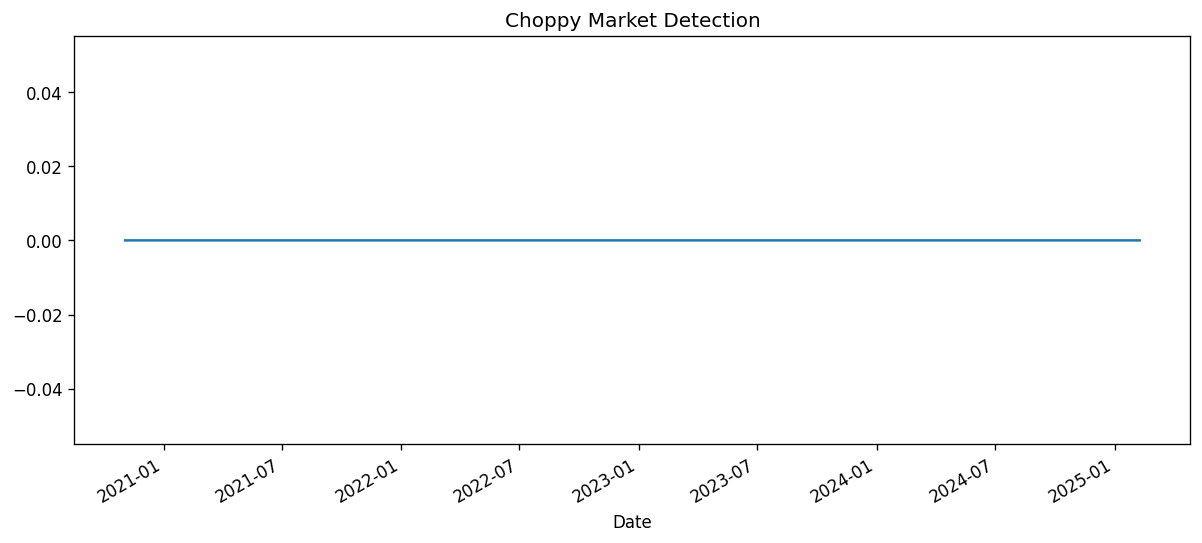

In [9]:
# Backtest logic
capital = 10000
position_size = 0  # Initial position
risk_per_trade = 0.02  # 2% risk per trade

def backtest(df):
    global capital, position_size
    for i in range(1, len(df)):
        row = df.iloc[i]
        if row["Signal"] == "Buy" and capital > 0:
            position_size = (capital * risk_per_trade) / row["Close"]  # Dynamic size
            capital -= position_size * row["Close"]
        elif row["Signal"] == "Sell" and position_size > 0:
            capital += position_size * row["Close"]
            position_size = 0

df.dropna(inplace=True)
backtest(df)

print(f"Final Capital: {capital:.2f}")

# Plot choppy market detection
df["Choppy_Market"].astype(int).plot(title="Choppy Market Detection", figsize=(12,5))
plt.show()